In [28]:
import numpy as np
import matplotlib.pylab as plt
import seaborn as sb
from scipy.spatial.distance import cdist
from scipy.integrate import odeint
import warnings
import sys
from tqdm import tqdm
warnings.simplefilter('error')


"""
This program simulated of  water drop.


State of code : Work in progress.

    - Simulation of one water with SPH. 
    - Verlet integration
    - Warning problems in the integration
    
Based on: PHYSICAL REVIEW E 96, 033115 (2017)
Autor: Hernan Salinas 
Date_update : 2/21/2021
"""


'\nThis program simulated of  water drop.\n\n\nState of code : Work in progress.\n\n    - Simulation of one water with SPH. \n    - Verlet integration\n    - Warning problems in the integration\n    \nBased on: PHYSICAL REVIEW E 96, 033115 (2017)\nAutor: Hernan Salinas \nDate_update : 2/21/2021\n'

# SPH 
Un fluido en cada punto y en cada momento tienen  propiedades como densidad, presión, temperatura, energía interna específica, 
energía potencial gravitacional, viscosidad entre otras propiedades. Las leyes físcas por las 
que se rigen son las leyes de la graviatación, las leyes de la hidrodinámica, la termodinámica, los 
modelos fisicos por los que se rigen son las leyes de Newton, ecuación de continuidad, ecuación de 
Poisson y las ecuaciones de estado.
La solución del  problema con todas sus propiedades involucra gran calculo matematico y computacional, es 
por ello que se realizan las siguentes aproximaciones.

- El fluído completo se discretiza en un conjunto de partículas distribuidas $"$arbitrariamente$"$ en el espacio.
-Cada partícula tiene una posición en el espacio del fluido correspondiente a una parcela del fluido 
obervada.
- La velocidad de cada partícula es igual a la velocidad de la parcela de fluido observado.
- Las particulas más que partículas reales, son puntos de observación en el fluido, esta aproximación 
implica la formuluacion lagrangiana en la descripción del fluido.
- Las propiedades "continuas" del fluido se calcular interpolando las propiedades medidas en el lugar
de cada parcela.
- Las propiedades evaluadas sobre la posición de una parcela del fluido se calcula como 
  $q(r)= \int q(r')W(r-r',h)d^3r' $, donde $W(r,h)$ es la función de interpolación.



## Kernel 
Para calcular las propiedades  de un fluído se puede  interpolar las propiedades en cada punto del espacio
en el que se encuentran las parcelas, para ello se  emplea una función de interpolación o kernel de interpolación,
dos tipos de kernel son mostrados en la figura 1 uno gaussiano y otro polinomial, estos kernel estan dados por la ecuaciónes siguientes ecuaciones 
respectivamente:

## Wendland

\begin{equation}
W(R, h)=\alpha \left\{
  \begin{matrix} \left(1-\frac{|r|^3}{h}\right) &  0\leq r< h \\ 
  0 & if \geq h
  \end{matrix}
\right.
\end{equation}

donde $\alpha_k=168/16\pi h^3$


## Gaussian
\begin{equation}
 W(R,h)=W_{o} e^{-(r/h)^2}
\end{equation} 


## Polynomial
\begin{equation}
 W(R,h)=Wo \left\{ \begin{array}{ll}
         4-6(\frac{R}{h})^2+3(\frac{R}{h})^3 & \mbox{si $ 0 <= R <= h $};\\
         |2-\frac{R}{h}|^3 & \mbox{si $h \leqq R <= 2h$}.\\
 0 & \mbox{si $R > 2h$ }          \end{array} \right. 
\end{equation} 

Este kernel difiere del reportado en el articulo Shigorina et al 2017

In [29]:
def Wendland(R,h):
    """
    Kernel for calculation of the Navier-Stokes momentum equation 
    Input : 
    R:  particle separation
    h: lenght of particle
    Outpunt: 
    Wenaldn kernel
    """
    α = 168/(16*np.pi*h**3) #dim=3
    α = 4.79/(1*np.pi*h**2) #dim=2 #Revisar estos valores
  
    q = R/h

    if 0 <= q < 1:
        
        W = (1 - q )**3
    else: 
        W = 0
        
    return W*α  
    
def Wendland_p(R,h):
    """
    Derivate of Wenland Kernel 
    
    Input:
    R:  particle separation
    Output: kernel W
    """
    α = 4.79/(1*np.pi*h**2) #dim=2 #Revisar estos valores
    q = R/h

    if 0 <= q < 1:
       
        W = - (3./h) * (1 - q ) ** 2
    else: 
        
        W = 0
        
    return W*α
    
    
def KernelGaussian(R,h):
    """
    Input: Radii of particle and h 
    Output: Kernel values W
    """
    q = R/h

    Wo = (np.pi * h **2) ** ( -1 / 2)
    W  = Wo * np.exp(- q ** 2)

    return W



def KernelPolynomial(R,h):
    """
    Input: Radii of particle and h 
    Output: Kernel W
    """ 
    
    
    W0 = 15./(7 * np.pi*h) #1.0# (np.pi * 4 * h** 3) ** (-1)
    W = 0
    q = R/h

    if 0 <= q <  1:
        
        W = (4 - 6* q  ** 2 + 3  * q **3)
    
    elif  1 <= q < 2:
        
        W =   (2 - q ) ** 3 #(1./4) * (2 - ( q )) ** 3
    
    elif q >= 2:
        
        W = 0
        
    else:
        print("Error kernel Polynomial!",R)
    
    return W


def kernelPolynomial_p(R, h):
    #REvisar si es utlizado
    W0 = 15/(7 * np.pi*3*h**2)# (np.pi * 4 * h** 3) ** (-1)
    #W = 0
    q = R/h
    
    if 0. <= q <  1:
        
        W = -12*q+9*q**2 #-(3./h) * q + (9./(4*h)) * q **2
    
    elif  1 <= q < 2:
        
        W = -3*(2-q)**2#-(3./(4*h)) * (2 - ( q )) ** 2
    
    elif q >= 2:
        
        W = 0
        
    else:
        print("Error kernel Polynomial!",R)
    
    return W
    
    
    
 #ref https://pysph.readthedocs.io/en/latest/reference/kernels.html


In [30]:
h = 0.1
step =  h /1000
R = np.arange(0, 4*h, step)

#KG = KernelGaussian(R, h) #kernel gaussiano
#KP = kernelPolinomial_(R, h) #kernel gaussiano
KP = np.array([KernelPolynomial(r,h) for r in R]) # kernel polinomial

KP_p = np.array([kernelPolynomial_p(r,h) for r in R]) #derivate of kernel polinomial 

W  = np.array([Wendland(r, h) for r in R])
Wp  = np.array([Wendland_p(r, h) for r in R])


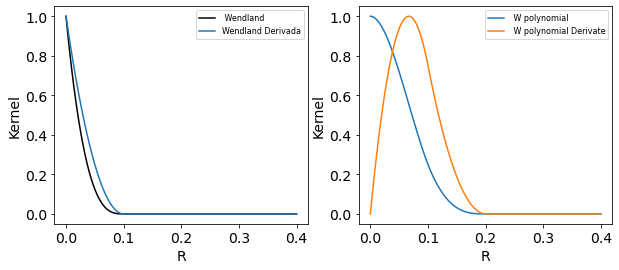

In [31]:
plt.figure(figsize=(10,4))
plt.subplot(121)
#plt.plot(R, KG/np.max(KG), label = "W gaussian")
plt.plot(R, W/np.max(W), "k-", label = " Wendland")
plt.plot(R, Wp/np.min(Wp), label="Wendland Derivada")
plt.xlabel("R",  fontsize=14)
plt.ylabel("Kernel", fontsize=14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(fontsize = 8)

plt.subplot(122)
plt.plot(R, KP/np.max(KP),  label = " W polynomial")
plt.plot(R, KP_p/np.min(KP_p),  label = " W polynomial Derivate")

plt.xlabel("R",  fontsize=14)
plt.ylabel("Kernel", fontsize=14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(fontsize = 8)
plt.show()

# Navier Stokes equations

## Continuity equation, mass conservation 


\begin{equation}
\frac{\mathrm{D} \rho}{\mathrm{D} t} = -\rho \nabla \cdot \vec{v}
\end{equation}

$\rho$ density and $v$ is the velocity 

## Momentum conservation 

## Euler description:

\begin{equation}
\frac{\mathrm{D} \vec{v}}{\mathrm{D} t} = -\frac{1}{\rho} \nabla P + \frac{\mu}{\rho} \nabla^2 \vec{v} + \vec{g}
\end{equation}

$\frac{D}{Dt}$ is the sutancial derivative for the velocity field $v$ , P is the preasure, g is the gravity and $\mu$ is the viscosity. The term $\nabla P$ is the force due to the change of the preasure, $\mu \nabla^2 v$ is the disipativy force, and $g$ has relation with weight of fluid. In the lagrangian description the navier stokes is for each particle in the fluid. 

## Lagrangian description:

In the langrangian description each particle has a position  $\vec{r}_i$ with velocity $\vec{v}_i$, mass ${m}_i$ and density $\rho_i$. The motion of equation for the all system are given by:

\begin{equation}
\frac{\mathrm{d}\vec{v}_i}{\mathrm{d}t} = - \sum_{j=1} ^N \left( \frac{P_j}{\rho_j^2}+ \frac{P_i}{\rho_i^2} \right)\frac{\vec{r}_{ij}}{r_ij}  \frac{\mathrm{d} W_{ij}}{\mathrm{d}r_{ij}} + 2\mu\sum_{j=1}m_j \frac{\vec{v}_{ij}}{\rho_i \rho_j r_{ij}} + \vec{g} + \frac{1}{m_i} \sum_{j=1}^{N} \vec{F_{ij}}
\end{equation}


Particle-particle interaction force for generate the surface tension and fluid weeting behavior.

\begin{equation}
\vec{F}_{ij} = s_{ij} \left[ A_{ij} \tilde{W}(r_{ij},h/2)- \tilde{W}(r_{ij},h) \right] \frac{\vec{r}_{ij}} {r_{ij}} 
\end{equation}



$s_{ij}$ surface tension, $A_{ij} $ is the Microscopic contact angle $A_{ff}=8$, $A_{sf}=24$. Where 



\begin{equation}
 \tilde{W}(R,h) =  \left\{ \begin{array}{ll}
         1-\frac{3}{2}(\frac{R}{h})^2+\frac{3}{4}(\frac{R}{h})^3 & \mbox{si $ 0 <= R <= h $};\\
         \frac{1}{4}(2-\frac{R}{h})^3 & \mbox{si $h \leqq R <= 2h$}.\\
 0 & \mbox{si $R > 2h$ }          \end{array} \right. 
\end{equation} 


# PF-SPH discretization 
Pairwise force with smoth particle hydrodynamics

## Density 
The density is obtained from the kernel summation 

\begin{equation}
\rho_i=\sum_{j=1}^{N} m_j W(\vec{r}_{ij}, h)
\end{equation}


## EOS equation 
\begin{equation}
P = Po \left[ \left( \frac{\rho}{\rho_0}\right)^2 -1 \right]
\end{equation}


where

\begin{equation}
Po=\frac{c^2\rho_0}{\gamma}
\end{equation}

- The density of water is  $\rho = 1\times 10^3\mathrm{kg/m^3}$,  the speed of the sound $c$ and the constante $\gamma=3$. This values of $\gamma$ is for aproximate the system to incomprensible fluid, in this case the ratio $\delta \rho/ \rho< 0.3\%$



#$ Algoritm

1. Generate particles in uniform cubi lattice with  red parameter $a= 0.5\times \mathrm{10}^{-4}$



In [32]:
def eos(P0,  ρ, ρ0,γ):
    """
    State equation, Batchelor and Monaghan
    """
    return P0 * ((ρ / ρ0) **γ - 1)

In [33]:
# Initial condition
def init_positions(a, Np):
    """
    Return the position r=(x, y) of particle 
    in regular grid for lagrangian representation
    --Input--   
    a: Red parameter
    Np: Particles in one dimension, The total particle is Np*Np
    --Output--
    array with position x, y
    """
    #Grid representation
    x = np.arange(0, a*Np,a)
    y = np.arange(0, a*Np,a)    
    X,Y = np.meshgrid(x , y)  # Grid of particle in 2D 
    #Particle-particle representation
    xp = X.flatten() #all position in x 
    yp = Y.flatten() #all position in y
    pos_r = np.transpose(np.array([xp,yp]))
    
    return pos_r

def init_velocity(Np, v0 = 0) : 
    
    """
    Return the position v=(vx, vy) of particle 
    in regular grid for lagrangian representation
    --Input--   
    v0: magnitud of the distribution velocity    
    Np: Particles in one dimension, The total particle is Np*Np
    --Output--
    array with position vx, vy
    """    
    
    vx = v0 * np.random.random(Np)
    vy = v0 * np.random.random(Np)
    vX, vY = np.meshgrid(vx, vy)
    vxp = vX.flatten() #position 
    vyp = vY.flatten() #posicion
    vel = np.transpose(np.array([vxp, vyp]))
    return vel


def force_ij(Rij, R, h,sij=1, Aij=1):
    """
    Calculation the force
    --Input--  
    Rij   : Vector ΔR_ij= (Δx,Δy,Δz)_ij 
    R     : Magnitud of vector |ΔR|
    h     : Compact support
    sij   : Magnitud of surface tension, 
            s_ff, fluid-fluid interaction
            s_sf, Fluid-solid intetaraction 
    Aij   : Microscopic static contact angle
      
    --Output--:
    
    """
    #Calculo del kernel de la fuerza
    Wij_1 = KernelPolynomial(R, 0.5*h)
    Wij_2 = KernelPolynomial(R, h)
    #Cálculo de la fuerza
    Fij = sij * ( Aij * Wij_1 - Wij_2)
    return Fij

In [34]:
def compute_force_i(i, pos_r, vel, ρ, mass ):
    """
    --Input--
    i  :i-th particle
    pos: vector pos_r
    vel: vector velocity
    ρ   :density 
    P   : Preasure
    mass   : mass
    
    --Output--
    dvdt, ρ, P
    Force the i-th particle
    
    """
    g     = np.array([0, 0])
    R     = np.zeros((Nt,Nt))
       
    densidad = 0
    Fij = 0
    T2  = 0
    T1  = 0
    P     = eos(P0,  ρ, ρ0,γ) #initial Preasure
        
    for j in range(0, Nt):
        if(i != j):
            
            Rij = pos_r[j] - pos_r[i] #vector
            R[i,j] = np.linalg.norm(Rij)         #magnitude
            vij    = vel[j] - vel[i]        #vector
            Kernel = Wendland(R[i,j],h)
            derivadaKernel = Wendland_p(R[i,j],h)
            #PairWise 
            Fij += force_ij(Rij, R[i,j], h) * (Rij / R[i,j])
            #Density-velocity termn
            T2  += mass[j] / (R[i,j] * ρ[i] * ρ[j])  * derivadaKernel * vij 
            #Preasure term
            T1  += mass[j] *  (P[j] / ρ[j] ** 2 + P[i] / ρ[i] ** 2) * derivadaKernel * (Rij/R[i,j]) 
            
            densidad += mass[j] * Wendland(R[i,j], h) 
            #dρdt[j]  += mass[j]*(vel[i]-vel[j])*Kernel
            #densidad += mass[j] * np.dot(vel[i] - vel[j], Kernel * (Rij / R[i,j]))
            
    dvdt = Fij / mass[i] + g + 2 * μ * T2 - T1
    ρ    = densidad
    P    = eos(P0,  ρ, ρ0,γ)
    return  dvdt,ρ, P 


In [47]:
Np = 20     #Particle along x-axis
Nt = Np ** 2 #Total particles

#======================
# Parameter 
#======================
a     = 1 * 0.5E-5      # Red parameter
ρ0  = 1000            # kg/m^3    Water density
μ   = 0.001296           # Pa,s      Viscosity
m0  = ρ0*(a*Np)**2/(Nt)      # 1.25E-10 #kg mass
print(m0)
h   = 1.71E-4           # step
c   = 4.5               # m/s speed of sound   
gravity  = 9.81         # m/s^2  gravity
Aij = 8                # Aff=8, Asf=24
sij = 1
γ   = 3                 #
P0  = c ** 2 * ρ0 / γ   #


pos_r = init_positions(a, Np)
vel   = init_velocity(Np)
#Presion Condiciones iniciales


2.5000000000000002e-08


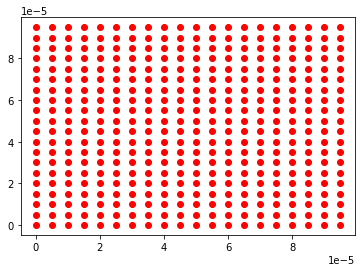

In [48]:
plt.plot(pos_r[:,0],pos_r[:,1], "ro")

In [49]:
#g     = np.array([0, gravity])
mass  = m0 * np.ones(Nt) # mass
ρ     = ρ0 * np.ones(Nt) # density for each particle 
#P     = eos(P0,  ρ, ρ0,γ) #initial Preasure


In [50]:
#Force for each particle.
def force_per_particle(Nt, pos_r, vel, ρ, mass):
    """
    Compute the force for each particle
    --Input--
    pos_r= vector with the position of particles. Dimension(Nt,2)
    vel  = vector with the velocity of particles. Dimension(Nt,2)
    ρ    = vector with the density of particle.   Dimension(Nt,1)
    mass = vector the mass
   
    --Output--
    dvdt = vector with the aceleration.          Dimension(Nt, 2)
    ρ_   = Vector of density for each particle.  Dimension(Nt, 2)
    P_   = Preasure for each particle.           Dimension(Nt, 1)
    """
#    drdt = np.zeros((Nt,2))
    dvdt = np.zeros((Nt,2))
    ρ_   = np.zeros(Nt)
    P_   = np.zeros(Nt)

    for i in range(0, Nt):
        dvdt[i], ρ_[i], P_[i] = compute_force_i(i, pos_r, vel, ρ, mass )
    return dvdt, ρ_, P_
   

In [51]:
dvdt, ρ_, P_ = force_per_particle(Nt, pos_r, vel, ρ, mass)

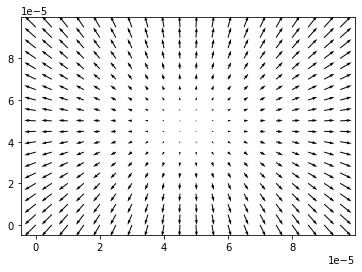

In [52]:
plt.quiver(pos_r[:,0], pos_r[:,1], dvdt[:,0], dvdt[:,1])

# Velocity Verlet integration
- 
\begin{equation}
v_i \left(t+\frac{1}{2}\Delta t\right )  = v_i +\frac{1}{2}a_i(t)
\end{equation}

- 
\begin{equation}
\bar{v}_i \left(t + \Delta t\right )  = v_i +  a_i(t)
\end{equation}

-
\begin{equation}
a_i(t+\Delta t) = \frac{\bar{v}_i (t+ \Delta t) -v_i(t + 0.5\Delta t)}{0.5 \Delta t}
\end{equation}

- 








In [62]:
dt     = 0.25 * h / (3 * c * 100)
time   = np.arange(0, 1E-5, dt/2)
n      = len(time) 


In [63]:
#Inicialization of variables and build array
v_medio   = np.zeros((n, Nt, 2))
v_gorro   = np.zeros((n, Nt, 2))
ρ_medio   = np.zeros((n, Nt))
r         = np.zeros((n, Nt, 2))
v         = np.zeros((n, Nt, 2))
a         = np.zeros((n, Nt, 2))
_ρ_       = np.zeros((n, Nt))
_P_       = np.zeros((n, Nt))
velocidad = np.zeros((n, Nt, 2))


#Initial values/
r[0]    = pos_r 
v[0]    = vel
a[0]    = dvdt
_ρ_[0]  = ρ_
_P_[0]  = P_

In [64]:
k = 80 #deberia ser n

In [65]:
loop = tqdm(total=k, position=0, leave=False)

for i in range(0, k, 2):
    loop.set_description("loading ...".format(i))
    loop.update(2)
    
    
    v[i + 1] = v[i] + dt * 0.5 * a[i]

    v_gorro[i + 2] = v[i] + dt * 1.0 * a[i]

    ρ_medio[i + 1] = _ρ_[i]   #+0.5*dρdt

    r[i + 2]       = r[i] + dt * v[i + 1] 
    try:
       
        a[i+2],_ρ_[i+2],_P_[i+2] = force_per_particle(Nt, r[i + 2], v_gorro[i + 2], ρ_medio[i + 1], mass)
    except:
        print("Unexpected error:", sys.exc_info()[0]) 
        print(i)
        break
    v[i + 2] = v[i + 1] + 0.5 * dt * a[i+2] 
     

loading ...:  60%|█████████████████████████████████████████▍                           | 48/80 [01:47<01:14,  2.33s/it]

Unexpected error: <class 'RuntimeWarning'>
46


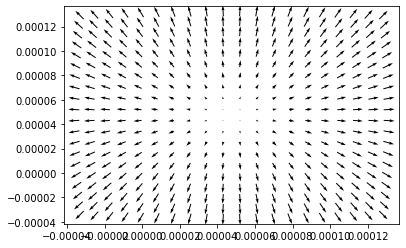

In [66]:
k = 4
plt.quiver(r[k][:,0],r[k][:,1], a[k][:,0], a[k][:,1])

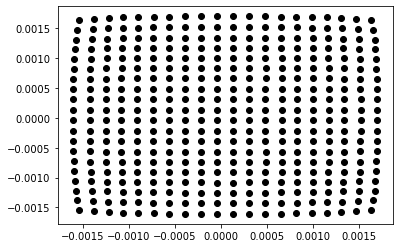

In [61]:
plt.plot(r[k][:,0],r[k][:,1], "ko")